In [17]:
import operator, os, sqlite3, warnings
from dotenv import load_dotenv
from langgraph.graph import StateGraph, END, START
from langchain_tavily import TavilySearch
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated, List
from pydantic import Field, BaseModel
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from IPython.display import display, Markdown, Image

warnings.filterwarnings("ignore")

In [2]:
os.makedirs("database", exist_ok=True)
if not os.path.exists(os.path.join("database", "essay_writter.db")):
    conn = sqlite3.connect(os.path.join("database", "essay_writter.db"), check_same_thread=False)
else:
    conn = sqlite3.connect(os.path.join("database", "essay_writter.db"), check_same_thread=False)

checkpointer = SqliteSaver(conn=conn)

In [5]:
search = TavilySearch(max_results=2)
llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0)
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [6]:
class AgentState(TypedDict):
    task: str = Field(..., description="The main essay topic or objective provided by the user.")
    plan: str = Field(..., description="A structured outline or plan for writing the essay.")
    draft: str = Field(..., description="The current version of the essay generated based on the plan and content.")
    critique: str = Field(..., description="Feedback and improvement suggestions for the current draft.")
    content: List[str] = Field(..., description="Relevant reference information and research data gathered for the essay.")
    revision_number: int = Field(..., description="The current iteration number of the essay revision process.")
    max_revisions: int = Field(..., description="The total number of revisions allowed before finalizing the essay.", max_length=3)

class Queries(BaseModel):
    queries: List[str] = Field(..., description="A list of search queries to retrieve relevant research information.")

In [7]:
model.invoke("Hi").content

'Hello! How can I assist you today?'

In [8]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed:

------

{content}"""

REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""

RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""

In [9]:
response = search.invoke("What is langgraph?")

In [10]:
for r in response['results']:
    print(r["content"], "\n")

LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph allows you to create custom node types to implement complex agent logic. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interactions. 

* LangGraph is a library built on top of Langchain that is designed to facilitate the creation of cyclic graphs for large language model (LLM) – based AI agents. * Langgraph introduces a chat agent executor that represents the agent state as a list of messages, which is particularly useful for newer, chat-based models. The agent executor class in the Langchain f

In [11]:
def plan_node(state: AgentState) -> AgentState:
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages).content
    return { "plan": response}

def research_plan_node(state: AgentState) -> AgentState:
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = search.invoke(q)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

def generation_node(state: AgentState) -> AgentState:
    content = "\n\n".join(state['content'] or [])
    messages = [
        SystemMessage(content=WRITER_PROMPT.format(content=content)),
        HumanMessage(content=f"""{
            state['task']}\n\nHere is my plan: {state['plan']}""")
    ]
    result = model.invoke(messages).content
    return {
        "draft": result,
        "revision_number": state.get('revision_number', 1) + 1
        }

def reflection_node(state: AgentState) -> AgentState:
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    critique = model.invoke(messages).content
    return {"critique": critique}

def research_critique_node(state: AgentState) -> AgentState:
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = search.invoke(q)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

def should_continue(state: AgentState) -> AgentState:
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [12]:
graph = StateGraph(AgentState)

graph.add_node("planner", plan_node)
graph.add_node("generate", generation_node)
graph.add_node("reflect", reflection_node)
graph.add_node("research_plan", research_plan_node)
graph.add_node("research_critique", research_critique_node)

graph.set_entry_point("planner")

graph.add_edge("planner", "research_plan")
graph.add_edge("research_plan", "generate")
graph.add_conditional_edges("generate", should_continue, {END:END, "reflect": "reflect"})
graph.add_edge("reflect", "research_critique")
graph.add_edge("research_critique", "generate")


workflow = graph.compile(checkpointer=InMemorySaver())

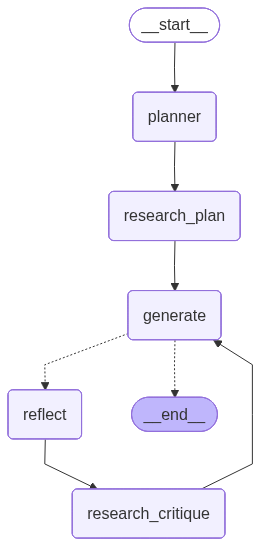

In [16]:
Image(workflow.get_graph().draw_mermaid_png())

In [18]:
config = { 'configurable': { 'thread_id': '1' } }

initial_state = {
    'task': "what is the difference between langchain and langsmith",
    "content" : [],
    "max_revisions": 2,
    "revision_number": 1}

result = workflow.invoke(initial_state, config=config)

In [19]:
sections = []
for key, value in result.items():
    sections.append(f"### **{key.capitalize()}**\n{value}\n")

output_text = "\n---\n".join(sections)
display(Markdown(output_text))

### **Task**
what is the difference between langchain and langsmith

---
### **Plan**
I. Introduction
    A. Brief overview of Langchain and Langsmith
    B. Thesis statement: Exploring the differences between Langchain and Langsmith

II. Langchain
    A. Definition and explanation
    B. Key features and characteristics
    C. Use cases and applications
    D. Advantages and disadvantages

III. Langsmith
    A. Definition and explanation
    B. Key features and characteristics
    C. Use cases and applications
    D. Advantages and disadvantages

IV. Comparison between Langchain and Langsmith
    A. Technology stack
    B. Scalability
    C. Security
    D. Interoperability
    E. Performance

V. Conclusion
    A. Recap of main differences between Langchain and Langsmith
    B. Implications for future developments in the field
    C. Final thoughts on the significance of understanding these differences

---
### **Draft**
**Title: Unveiling the Contrasts: LangChain vs. LangSmith in Large Language Model Development**

I. Introduction
LangChain and LangSmith are two pivotal tools developed by LangChain, each serving distinct purposes in Large Language Model (LLM) applications. This essay delves into the disparities between LangChain and LangSmith to illuminate their unique functionalities.

II. LangChain
LangChain is a tool tailored for early-stage prototyping and small-scale applications in LLM development. It offers an open-source framework with modular chains, sequences, and a wide range of model support. While efficient for building LLM applications, LangChain may lack scalability for large production environments.

III. LangSmith
In contrast, LangSmith provides a comprehensive platform ideal for large-scale, production-ready LLM applications. It focuses on managing, debugging, and orchestrating complex AI models in production environments, offering advanced debugging, testing, and monitoring capabilities.

IV. Comparison between LangChain and LangSmith
A. Technology Stack: LangChain emphasizes building blocks for LLM applications, while LangSmith prioritizes observability and evaluation tools.
B. Scalability: LangChain is limited in scalability for large-scale production, whereas LangSmith excels in managing large, complex AI systems.
C. Security: Both tools prioritize security, but LangSmith's focus on monitoring and debugging enhances security measures.
D. Interoperability: LangChain and LangSmith offer different levels of interoperability based on the stage and requirements of LLM development.
E. Performance: LangChain is efficient for prototyping, while LangSmith ensures high performance in large-scale, production-ready applications.

V. Conclusion
In conclusion, understanding the distinctions between LangChain and LangSmith is crucial for developers in the LLM application space. While LangChain caters to early-stage development, LangSmith is indispensable for advanced production environments. Recognizing these differences is vital for optimizing LLM applications and driving future advancements in the field.

---
### **Critique**
Overall, your essay provides a clear overview of the differences between LangChain and LangSmith in the context of Large Language Model development. Here are some suggestions to enhance your submission:

1. **Introduction**: Your introduction sets the stage well by introducing LangChain and LangSmith. Consider adding a brief overview of the importance of Large Language Models in the current AI landscape to provide more context to the reader.

2. **LangChain and LangSmith Descriptions**: Your descriptions of LangChain and LangSmith are informative. To improve, consider providing specific examples or case studies where each tool has been successfully utilized. This will help illustrate the practical applications of these tools.

3. **Comparison Section**: Your comparison section is structured well with clear subheadings. To enhance this section, consider providing more detailed examples or scenarios where the differences between LangChain and LangSmith become crucial. Additionally, you could include a discussion on the cost implications of using each tool, as this is often a significant factor in decision-making.

4. **Conclusion**: Your conclusion effectively summarizes the key points discussed in the essay. To strengthen it, consider adding a call to action or a recommendation for developers on when to choose LangChain over LangSmith or vice versa based on specific project requirements.

5. **Depth and Detail**: While your essay provides a good overview, consider expanding on each tool's features, functionalities, and limitations. Providing more in-depth analysis and real-world examples will enrich your discussion and make it more engaging for the reader.

6. **Style and Tone**: Ensure consistency in your writing style and tone throughout the essay. Aim for a formal and professional tone given the technical nature of the topic.

7. **Length**: Consider expanding on each section to provide a more comprehensive analysis of LangChain and LangSmith. Aim for a more detailed exploration of the tools, their capabilities, and their implications in Large Language Model development.

Overall, your essay is well-structured and informative. By incorporating the above suggestions, you can further enhance the depth and clarity of your analysis on the contrasts between LangChain and LangSmith in Large Language Model development.

---
### **Content**
['LangChain and LangSmith are two powerful tools developed by LangChain, a company focused on making it easier to build and deploy Large Language Model (LLM) applications. 1. Limited Scalability: LangChain is not designed for large-scale production environments, making it less suitable for complex, high-traffic applications. 1. Comprehensive Platform: LangSmith offers a unified platform for managing all aspects of LLM development, making it ideal for large-scale, production-ready applications. LangChain and LangSmith are two complementary tools that cater to different stages and requirements of LLM development. LangChain is ideal for early-stage prototyping and small-scale applications, while LangSmith is better suited for large-scale, production-ready applications that require advanced debugging, testing, and monitoring capabilities. ## Understanding LangChain Tools and Agents: A Guide to Building Smart AI Applications', 'Meanwhile, Langsmith focuses on managing, debugging, and orchestrating more complex AI models in production environments. Whether you\x80\x99re building a chatbot or an AI-powered research tool, Langchain allows you to connect multiple models in sequence, creating a powerful and flexible system for handling complex tasks. Langsmith steps in to give you the tools you need to **debug** and monitor your models at scale, ensuring everything is running as expected in your AI system. If you\x80\x99re responsible for ensuring your AI models work in production, or you need to frequently debug and monitor your pipelines, Langsmith is your go-to tool. In short, while **Langchain** excels at managing and scaling model workflows, **Langsmith** is designed for those times when you need deep visibility and control over large, complex AI systems in production.', 'In LLM application development, LangChain and LangSmith have become central tools for building and managing large language model-powered solutions. This article compares LangChain and LangSmith, focusing on their core features, integration options, and value for developers in the LLM application space. LangChain is an open-source framework that helps developers create LLM applications efficiently. LangSmith provides tools to debug, monitor, and improve LLM-powered agents, and offers a managed cloud service with a web UI. | LLM Evaluation | Minimal built-in support; developers typically create custom logic or use external tools. | Key Features | Modular chains and sequences, prompt templates, agent framework, data connectors, wide model support, community integrations. LangChain provides building blocks for LLM applications, while LangSmith offers observability and evaluation.', 'Meanwhile, Langsmith focuses on managing, debugging, and orchestrating more complex AI models in production environments. Whether you\x80\x99re building a chatbot or an AI-powered research tool, Langchain allows you to connect multiple models in sequence, creating a powerful and flexible system for handling complex tasks. Langsmith steps in to give you the tools you need to **debug** and monitor your models at scale, ensuring everything is running as expected in your AI system. If you\x80\x99re responsible for ensuring your AI models work in production, or you need to frequently debug and monitor your pipelines, Langsmith is your go-to tool. In short, while **Langchain** excels at managing and scaling model workflows, **Langsmith** is designed for those times when you need deep visibility and control over large, complex AI systems in production.', 'LangChain and LangSmith are two powerful tools developed by LangChain, a company focused on making it easier to build and deploy Large Language Model (LLM) applications. 1. Limited Scalability: LangChain is not designed for large-scale production environments, making it less suitable for complex, high-traffic applications. 1. Comprehensive Platform: LangSmith offers a unified platform for managing all aspects of LLM development, making it ideal for large-scale, production-ready applications. LangChain and LangSmith are two complementary tools that cater to different stages and requirements of LLM development. LangChain is ideal for early-stage prototyping and small-scale applications, while LangSmith is better suited for large-scale, production-ready applications that require advanced debugging, testing, and monitoring capabilities. ## Understanding LangChain Tools and Agents: A Guide to Building Smart AI Applications', 'Meanwhile, Langsmith focuses on managing, debugging, and orchestrating more complex AI models in production environments. Whether you\x80\x99re building a chatbot or an AI-powered research tool, Langchain allows you to connect multiple models in sequence, creating a powerful and flexible system for handling complex tasks. Langsmith steps in to give you the tools you need to **debug** and monitor your models at scale, ensuring everything is running as expected in your AI system. If you\x80\x99re responsible for ensuring your AI models work in production, or you need to frequently debug and monitor your pipelines, Langsmith is your go-to tool. In short, while **Langchain** excels at managing and scaling model workflows, **Langsmith** is designed for those times when you need deep visibility and control over large, complex AI systems in production.', 'Large language models (LLMs) are revolutionizing healthcare and biomedicine. They assist in medical diagnosis, literature review, and research analysis while', 'Large Language Models (LLMs) are reshaping AI in ways that go beyond simple text processing. But within this massive AI landscape, there’s a particular subfield that’s been making a lot of noise: *Large Language Models (LLMs)*. 3. **Generative AI**: LLMs play a central role in **Generative AI**, where AI systems create new content, such as text, images, or music. So, how do LLMs compare to other AI models? | Type of AI Model | Main Task | Examples | How It Compares to LLMs | 4. **Multimodal AI**: While LLMs primarily deal with text, they are increasingly being integrated with other forms of AI, such as vision models (like in **DALL·E** and **CLIP**), which combine text and image understanding.', "# Customers choose LangChain to build reliable agents ##### How Morningstar saves 30% of analysts' time with Mo, its AI Research Assistant ##### How Outshift by Cisco boosted productivity 10x with their AI Platform Engineer ##### How Modern Treasury built a financial operations AI agent More agent engineer stories ##### Klarna's AI Assistant speeds up customer resolution with LangSmith & LangGraph ##### How Replit uses LangSmith for improved agent performance ##### How C.H. Robinson transformed logistics shipments with LangSmith & LangGraph ##### Vizient provides reliable insights for healthcare providers with LangGraph & LangSmith ##### Unify launches agents for account qualification with LangGraph & LangSmith ##### Lovable scales its agent to $25M ARR in 4 months, gaining visibility with LangSmith", 'In LLM application development, LangChain and LangSmith have become central tools for building and managing large language model-powered solutions. This article compares LangChain and LangSmith, focusing on their core features, integration options, and value for developers in the LLM application space. LangChain is an open-source framework that helps developers create LLM applications efficiently. LangSmith provides tools to debug, monitor, and improve LLM-powered agents, and offers a managed cloud service with a web UI. | LLM Evaluation | Minimal built-in support; developers typically create custom logic or use external tools. | Key Features | Modular chains and sequences, prompt templates, agent framework, data connectors, wide model support, community integrations. LangChain provides building blocks for LLM applications, while LangSmith offers observability and evaluation.', "It comes in two plans: an open-source library, which is MIT-licensed and free to use, and a hosted LangGraph platform with paid tiers for deploying and scaling agentic workflows. Understanding LangGraph's pricing requires considering both the LangSmith subscription costs and the additional usage charges for running agents in production. * **Flexible deployment options:** Enterprise customers can deploy LangGraph wherever they need – this includes fully self-hosted on your own cloud or on-premises, or a hybrid model (LangChain runs the control plane while your infrastructure handles the data plane). While LangGraph excels at complex agent orchestration, teams should carefully evaluate whether they need its specialized features or if a more general-purpose MLOps framework like ZenML could meet their needs at a lower cost.", 'Is LangChain really free to use? Is LangChain really free to use? # Is LangChain really free to use? Whether you’re building a retrieval-augmented chatbot, a tool-using agent, or an end-to-end AI workflow, LangChain provides the abstractions to help you go from prototype to production. This interactive LangChain course integrates LLMs into AI applications, enabling developers to create smart AI solutions. LangChain’s open-source offering includes everything needed to get started with LLM applications: * **LangServe** is a free, open-source way to serve LangChain apps as APIs. However, hosting it still requires cloud resources that may cost money. Paid services like LangSmith, managed LLM endpoints, and hosted vector databases offer the performance, observability, and collaboration features needed for scaling LangChain into production environments. So, is LangChain free?']

---
### **Revision_number**
3

---
### **Max_revisions**
2
